## Importando biblioteca e instanciando classes

In [311]:
import pandas as pd
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import matplotlib.pyplot as plt
#sc = SparkContext('local')
sc = SparkContext.getOrCreate('local')
spark = SparkSession(sc)

### Processando dataset 1 - JSON File to TempView (TRIPS)

In [312]:
path = "data-sample*"
Trips = spark.read.json(path)
Trips.createOrReplaceTempView("trips")

### Processando dataset 2 - CSV File to TempView (VENDORS)

In [313]:
vendors_path = 'data-vendor_lookup.csv'
Vendors = spark.read.option("header",True).csv(vendors_path)
Vendors.createOrReplaceTempView("vendors")

### Processando dataset 3 - CSV File to TempView (PAYMENTS_LOOKUP)

In [314]:
paymn = pd.read_csv('data-payment_lookup.csv', skiprows=[0])
paymn.to_csv('data_payments.csv')
payments_path = 'data_payments.csv'
Payments = spark.read.option("header",True).csv(payments_path)
Payments.createOrReplaceTempView("payments")

## 1. Qual a distância média percorrida por viagens com no máximo 2 passageiros;

In [315]:
firstQuestion = spark.sql("SELECT AVG(trip_distance) avg_distance FROM trips WHERE passenger_count <= 2")

In [316]:
# firstQuestion.show()
distancia_media = firstQuestion.toPandas()
resultado = distancia_media['avg_distance'][0]
print(resultado)

2.6625269962032267


## 2. Quais os 3 maiores vendors  em quantidade total de dinheiro arrecadado;

In [317]:
secondQuestion  = spark.sql("""SELECT name, vendor_id,
                                    SUM(total_amount) total_arrecadado
                                FROM trips 
                                LEFT JOIN vendors using(vendor_id) 
                                GROUP by name, vendor_id 
                                ORDER BY total_arrecadado DESC""")

In [318]:
totalamount_vendors = secondQuestion.toPandas()

In [319]:
biggervendors = totalamount_vendors.head(3)

In [320]:
valores = biggervendors['total_arrecadado']
empresas = biggervendors['name']

In [321]:
biggervendors.dtypes

name                 object
vendor_id            object
total_arrecadado    float64
dtype: object

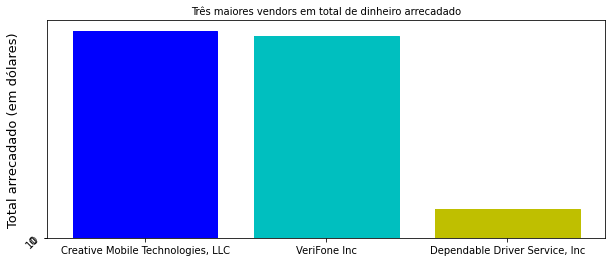

In [376]:
plt.bar(empresas, valores)
barlist = plt.bar(empresas, valores)
barlist[0].set_color('b')
barlist[1].set_color('c')
barlist[2].set_color('y')
plt.rcParams["figure.figsize"] = [10,4]
plt.xticks(fontsize=10)
plt.yticks([0, 10],fontsize=10, rotation=45)
plt.title("Três maiores vendors em total de dinheiro arrecadado", fontsize=10)
plt.ylabel("Total arrecadado (em dólares)", fontsize=13)
plt.savefig('foo.jpg')
plt.show()

## 3. Faça um histograma da distribuição mensal, nos 4 anos, de corridas pagas em dinheiro;

In [323]:
ThirdQuestion = spark.sql("""
                                SELECT  mes_corrida, count(1) qtde_corridas from (
                                SELECT 
                                    DATE_FORMAT(pickup_datetime, 'y-MM') mes_corrida, 
                                    payments.payment_lookup
                                FROM trips
                                LEFT JOIN payments ON
                                payments.payment_type = trips.payment_type
                                WHERE payment_lookup = 'Cash'
                                ) GROUP BY mes_corrida
                                """)

In [324]:
cashraces_month = ThirdQuestion.toPandas()

In [325]:
cashraces_month = cashraces_month.sort_values(by=['mes_corrida'])
cashraces_month.head()

,mes_corrida,qtde_corridas
2,2009-01,66991
44,2009-02,66820
40,2009-03,73945
39,2009-04,71141
36,2009-05,74136


In [326]:
meses = cashraces_month['mes_corrida']
qtdes = cashraces_month['qtde_corridas']

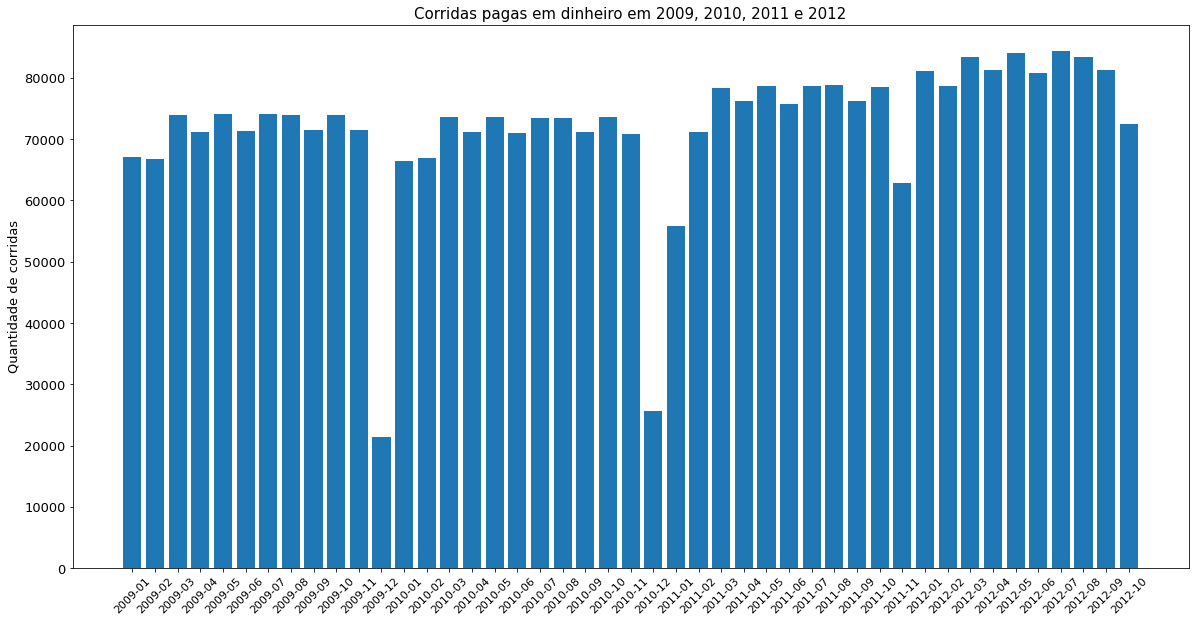

In [367]:
plt.bar(meses, qtdes)
# plt.rcParams["figure.figsize"] = [20,10]
# plt.set_size_inches(10,5)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=13)
plt.title("Corridas pagas em dinheiro em 2009, 2010, 2011 e 2012", fontsize=15)
plt.ylabel("Quantidade de corridas", fontsize=13)
figure = plt.gcf()
figure.set_size_inches(20, 10)
plt.show()

## 4. Faça um gráfico de série temporal contando a quantidade de gorjetas de cada dia, nos últimos 3 meses de 2012.

In [328]:
Desc = spark.sql("DESC trips")
Desc.show()

+------------------+---------+-------+
|          col_name|data_type|comment|
+------------------+---------+-------+
|  dropoff_datetime|   string|   null|
|  dropoff_latitude|   double|   null|
| dropoff_longitude|   double|   null|
|       fare_amount|   double|   null|
|   passenger_count|   bigint|   null|
|      payment_type|   string|   null|
|   pickup_datetime|   string|   null|
|   pickup_latitude|   double|   null|
|  pickup_longitude|   double|   null|
|         rate_code|   string|   null|
|store_and_fwd_flag|   bigint|   null|
|         surcharge|   double|   null|
|        tip_amount|   double|   null|
|      tolls_amount|   double|   null|
|      total_amount|   double|   null|
|     trip_distance|   double|   null|
|         vendor_id|   string|   null|
+------------------+---------+-------+



In [329]:
Gorjetas = spark.sql(""" SELECT DATE_FORMAT(pickup_datetime, 'y-MM-dd') dia_corrida, 
                                COUNT(1) gorjetas 
                                from trips 
                                WHERE tip_amount > 0
                                        AND DATE_FORMAT(pickup_datetime, 'y-MM-dd') BETWEEN '2012-10-01' AND '2012-12-31'
                                GROUP BY dia_corrida """)

In [330]:
corridas_gorjeta = Gorjetas.toPandas()

In [331]:
corridas_gorjeta.head()

,dia_corrida,gorjetas
0,2012-10-21,617
1,2012-10-06,615
2,2012-10-24,587
3,2012-10-23,611
4,2012-10-04,586


In [332]:
corridas_gorjeta = corridas_gorjeta.sort_values(by=['dia_corrida'])

In [333]:
corridas_gorjeta.head()

,dia_corrida,gorjetas
19,2012-10-01,604
22,2012-10-02,612
11,2012-10-03,606
4,2012-10-04,586
17,2012-10-05,618


In [334]:
dias = corridas_gorjeta['dia_corrida']

In [335]:
gorjetas = corridas_gorjeta['gorjetas']

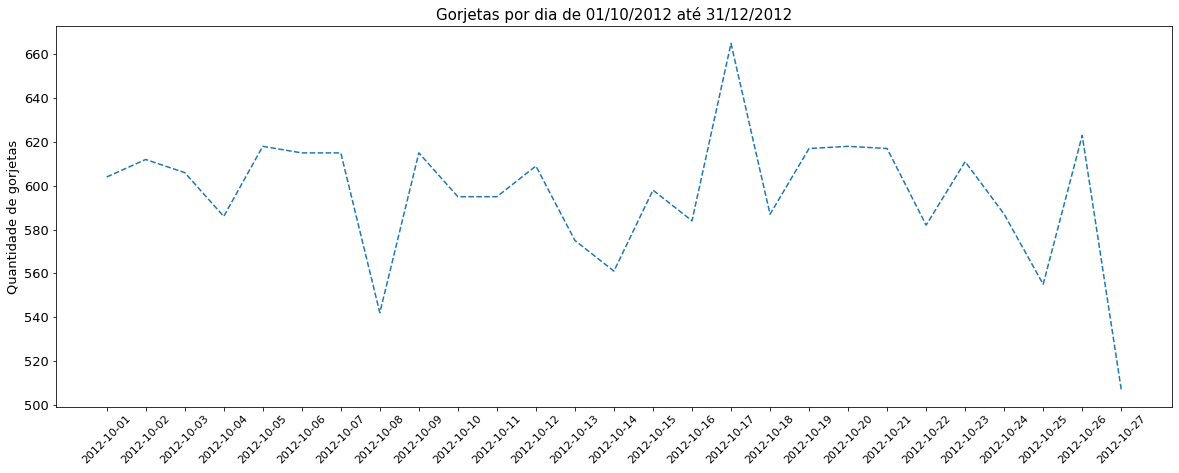

In [336]:
plt.plot(dias, gorjetas,  linestyle='--')
plt.rcParams["figure.figsize"] = [12,5]
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=13)
plt.title("Gorjetas por dia de 01/10/2012 até 31/12/2012", fontsize=15)
plt.ylabel("Quantidade de gorjetas", fontsize=13)
plt.show()

## Bonûs - Qual o tempo médio das corridas nos dias de sábado e domingo;

In [337]:
DayofWeek = spark.sql(""" SELECT    
                                    DAYOFWEEK(DATE_FORMAT(pickup_datetime, 'y-MM-dd')) day_of_week, 
                                    DATE_FORMAT(pickup_datetime, 'y-MM-dd H:mm:ss') inicio_corrida, 
                                    DATE_FORMAT(dropoff_datetime, 'y-MM-dd H:mm:ss') fim_corrida
                            FROM trips WHERE DAYOFWEEK(DATE_FORMAT(pickup_datetime, 'y-MM-dd')) IN (1,7)""")

In [338]:
DayofWeek.show()

+-----------+-------------------+-------------------+
|day_of_week|     inicio_corrida|        fim_corrida|
+-----------+-------------------+-------------------+
|          7| 2011-03-12 3:28:30| 2011-03-12 3:36:18|
|          1| 2011-08-07 1:03:02| 2011-08-07 1:09:58|
|          1| 2011-03-27 6:05:54| 2011-03-27 6:18:48|
|          7|2011-04-02 13:14:36|2011-04-02 13:20:57|
|          1|2011-07-17 18:45:07|2011-07-17 18:55:14|
|          7| 2011-04-16 7:12:11| 2011-04-16 7:23:25|
|          1|2011-04-03 15:25:51|2011-04-03 15:37:49|
|          1|2011-02-27 18:35:18|2011-02-27 18:42:30|
|          1| 2011-09-25 5:56:56| 2011-09-25 6:06:53|
|          1|2011-10-02 16:47:30|2011-10-02 16:57:05|
|          1| 2011-04-17 8:28:36| 2011-04-17 8:36:49|
|          7| 2011-07-30 7:16:27| 2011-07-30 7:27:47|
|          7| 2011-03-12 0:39:40| 2011-03-12 0:49:00|
|          7|2011-11-12 19:37:30|2011-11-12 19:45:45|
|          1|2011-04-17 22:17:06|2011-04-17 22:24:39|
|          1| 2011-03-20 8:1

In [339]:
corridas_fds = DayofWeek.toPandas()

In [340]:
corridas_fds.head()

,day_of_week,inicio_corrida,fim_corrida
0,7,2011-03-12 3:28:30,2011-03-12 3:36:18
1,1,2011-08-07 1:03:02,2011-08-07 1:09:58
2,1,2011-03-27 6:05:54,2011-03-27 6:18:48
3,7,2011-04-02 13:14:36,2011-04-02 13:20:57
4,1,2011-07-17 18:45:07,2011-07-17 18:55:14


In [341]:
corridas_fds['inicio_corrida_Date'] = corridas_fds['inicio_corrida'].astype('datetime64')
del corridas_fds['inicio_corrida']
corridas_fds['fim_corrida_Date'] = corridas_fds['fim_corrida'].astype('datetime64')
del corridas_fds['fim_corrida']

In [342]:
corridas_fds.dtypes

day_of_week                     int32
inicio_corrida_Date    datetime64[ns]
fim_corrida_Date       datetime64[ns]
dtype: object

In [343]:
corridas_fds.head()

,day_of_week,inicio_corrida_Date,fim_corrida_Date
0,7,2011-03-12 03:28:30,2011-03-12 03:36:18
1,1,2011-08-07 01:03:02,2011-08-07 01:09:58
2,1,2011-03-27 06:05:54,2011-03-27 06:18:48
3,7,2011-04-02 13:14:36,2011-04-02 13:20:57
4,1,2011-07-17 18:45:07,2011-07-17 18:55:14


In [344]:
corridas_fds.count()

day_of_week            1133178
inicio_corrida_Date    1133178
fim_corrida_Date       1133178
dtype: int64

In [345]:
elaptime = []
    
for i, row in corridas_fds.iterrows():
    elapsedTime = row['fim_corrida_Date'] - row['inicio_corrida_Date'] 
    elapsedTime = elapsedTime.total_seconds()
    elaptime.append(elapsedTime)   

In [346]:
corridas_fds['elapsedTime'] = elaptime

In [347]:
corridas_fds.head()

,day_of_week,inicio_corrida_Date,fim_corrida_Date,elapsedTime
0,7,2011-03-12 03:28:30,2011-03-12 03:36:18,468.0
1,1,2011-08-07 01:03:02,2011-08-07 01:09:58,416.0
2,1,2011-03-27 06:05:54,2011-03-27 06:18:48,774.0
3,7,2011-04-02 13:14:36,2011-04-02 13:20:57,381.0
4,1,2011-07-17 18:45:07,2011-07-17 18:55:14,607.0


In [348]:
corridas_fds['elapsedTime'].mean()

524.8284850217706

In [349]:
corridas_fds['Elap'] = corridas_fds['fim_corrida_Date'] - corridas_fds['inicio_corrida_Date'] 
print("\nDifference of score1 and score2 :\n", corridas_fds['Elap'].mean())


Difference of score1 and score2 :
 0 days 00:08:44.828485021


In [350]:
teste = corridas_fds['Elap'].mean()

In [351]:
def strfdelta(tdelta, fmt):
    d = {"days": tdelta.days}
    d["hours"], rem = divmod(tdelta.seconds, 3600)
    d["minutes"], d["seconds"] = divmod(rem, 60)
    return fmt.format(**d)

In [352]:
strfdelta(teste,"{minutes} minutos e {seconds} segundos")

'8 minutos e 44 segundos'

### 8 minutos e 44 segundos